# Homework 4 Step 1: K-Means Clustering

Here, we will explore the k-means clustering algorithm discussed in class, using the BBC Sports dataset. As with all unsupervised learning problems, our goal is to discover and describe some hidden structure in unlabeled data. Let us make the following assumption:  

Assumption: In the given data, the samples may be cleanly separated into k distinct groups over a set of features.

The issue therein is – while this assumption tells us that there are k distinct 'classes' of samples, we know nothing about their content/properties.  If we could find samples that were representative of each of the k groups, then we could label the rest of the samples based on how similar they are to each of the representative or prototypical samples.  Armed with this intuition, the goal of the k-means clustering algorithm will be to find these representative samples (prototypes) through an iterative process.

We can define such prototypes as either a:
centroid – the average of similar points wrt continuous features (e.g. petal lengths)
medioid – the most representative/most frequently occurring point wrt categorical features (e.g. discrete color labels, blue vs. red vs. green.)

## Step 1.1: Download and unzip the dataset

For this assignment you’ll use a dataset which clusters text articles from BBC Sports, by topic (athletics, cricket, football, rugby, tennis).  Download the preprocessed dataset from:

http://mlg.ucd.ie/datasets/bbc.html

(1) Download `bbcsport.zip` to your directory and (2) unzip bbcsport.zip into the four files contained therein. Leave these four files in your hw4 directory, i.e. do not put them in a data folder. For a completely optional additional challenge, do this within your notebook, using the `ZipFile` and `urlrequest.urlretrieve` packages. You will get all 0 points for Step 1.1, regardless of how you downloaded the data.

Look at the dataset's web page above to understand the role of each file.

Part of the task here is just for you to make sense of the data, and practice being a data scientist.  A few remarks that might help you:

* “Classes” are the five different topics, thus the class file may give a hint as to this (similarly with the docs file, which might be friendlier to read by a human).  Each document ID is ultimately mapped to a class.
* The mtx file represents a sparse matrix with counts of how often each word appeared in a document.  You may want to look at importing `scipy.io` and using `scipy.io.mmread` to read matrices, and the matrix `todense()` method to go from sparse to dense matrices.
* The ordering of the terms in the terms file implicitly gives you their word IDs.

In [1]:
# Popular imports, you may modify this if you need to add things

from urllib import request
import zipfile
import matplotlib
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn import preprocessing
import nltk

# For clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from statistics import mode

In [2]:
# TODO: download http://mlg.ucd.ie/files/datasets/bbcsport.zip and unzip
#
# Look up the Python docs for ZipFile and urlrequest.urlretrieve
# (remember to use Python 3.x)
#
# Worth 0 points

# YOUR CODE HERE
# raise NotImplementedError()

In [3]:
# Test that files exist
import os.path

if not os.path.isfile('bbcsport.classes'):
    raise ValueError("Don't appear to have successfully downloaded files")
    
if not os.path.isfile('bbcsport.mtx'):
    raise ValueError("Don't appear to have successfully downloaded files")

In [4]:
# mtx file should parse
#the sparse matrix currently only stores the non-zero elements by using coordinate-wise method
bbc_matrix = scipy.io.mmread('bbcsport.mtx')

#transform this into dense matrix
bbc_matrix = bbc_matrix.todense()
print(bbc_matrix.shape)



(4613, 737)


In [5]:
# mtx file should parse


## Step 1.2 - Data Prep

Load the data into a dataframe using any of the files you think are relevant. Columns should be terms and rows should be articles.

You should ultimately create a `bbc_df` dataframe in which each row is an article, and each column represents the number of times a given word (term) appears.  The resulting dataset should have shape (737, 4613).  

Also: read the class labels and turn them into a Pandas `Series` called `document_class` with column name `class_label`. This will be used at the end of the assignment.

In [6]:
# TODO: load the bbc_df and document_class
# 10 points
try:

    #create a df matrix by transposing
    bbc_df = pd.DataFrame(bbc_matrix, index = range(1,bbc_matrix.shape[0]+1), columns = range(1,bbc_matrix.shape[1]+1)).transpose()
    
    classes_df = pd.read_csv('bbcsport.classes', header = None, skiprows = 4, sep = ' ')
    classes_df.columns = ['obs','class_label']
    
    #check if there is any NaN values, and none is there
    nan_rows = classes_df[classes_df['obs'].isnull()]
    
    
    #convert into pandas series
    document_class = classes_df.loc[:,'class_label']
    

    
# YOUR CODE HERE
except:
    raise NotImplementedError()

In [7]:
document_class

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
707    4
708    4
709    4
710    4
711    4
712    4
713    4
714    4
715    4
716    4
717    4
718    4
719    4
720    4
721    4
722    4
723    4
724    4
725    4
726    4
727    4
728    4
729    4
730    4
731    4
732    4
733    4
734    4
735    4
736    4
Name: class_label, Length: 737, dtype: int64

In [8]:
bbc_df.shape


(737, 4613)

In [9]:
print(bbc_df)

     1     2     3     4     5     6     7     8     9     10    ...   4604  \
1     7.0   1.0   3.0   2.0   4.0   2.0   1.0   1.0   2.0   2.0  ...    0.0   
2     0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
3     0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   2.0  ...    0.0   
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
5     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...    0.0   
6     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
7     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
8     0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0  ...    0.0   
9     0.0   0.0   1.0   0.0   1.0   1.0   1.0   0.0   0.0   3.0  ...    0.0   
10    0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   2.0  ...    0.0   
11    0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  ...    0.0   
12    0.0   0.0   0.0   0.0   2.0   1.0   0.0   0.0 

In [10]:
document_class


0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
707    4
708    4
709    4
710    4
711    4
712    4
713    4
714    4
715    4
716    4
717    4
718    4
719    4
720    4
721    4
722    4
723    4
724    4
725    4
726    4
727    4
728    4
729    4
730    4
731    4
732    4
733    4
734    4
735    4
736    4
Name: class_label, Length: 737, dtype: int64

## Step 1.3 - K-Means

Now the question is -- how many clusters should we use?  We hinted above that the BBC dataset classified documents into five classes, but can we validate that the data supports one cluster per class?

First, turn the `bbc_df` into a matrix which we'll just call `X`.

In [11]:
# TODO: convert the dataframe to a matrix (worth 2 points)
try:
    X = bbc_df.values
    print(X.shape)
    
    
# YOUR CODE HERE
except:
    raise NotImplementedError()

(737, 4613)


In [12]:
print(X)

[[7. 1. 3. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]]


In [13]:
if X.shape != (737, 4613):
    raise ValueError('Expected something different than', X.shape)


Recall that in class, we described running K Means and plotting the **distortion** (sum of squared error given Euclidean distance).  From that we can find the "elbow" indicating the best tradeoff between number of clusters and distortion.


### 1.3.1 Testing Cluster Distortion

Define a function called `test_cluster_size` that iterates over possible cluster sizes from 2 to a `max_cluster` (inclusive) value.  The function should takes as input (1) the data as a matrix and (2) `max_cluster`.  It should return a list of scores, **where `max_cluster[i]` is the score for cluster size i**.  You should use `None` for cluster sizes 0 and 1.

Internally, you’ll want to use KMeans from `sklearn.cluster` to cluster your data.  As we saw from the slide examples, you can call the `fit` method over the data to generate clusters.  In each call, use random initialization of the centroids, with `max_iter=300`, `random_state=0`, and `n_init=30`.  It uses the term `inertia` to refer to distortion.

Also, you'll note from the `sklearn.cluster` documentation on __[KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)__:

Attributes:	
* cluster_centers_ : array, [n_clusters, n_features]
 Coordinates of cluster centers

* labels_ :
Labels of each point

* inertia_ : float
Sum of squared distances of samples to their closest cluster center.

* n_iter_ : int
Number of iterations run.


In [14]:
# TODO: write test_cluster_size
# Worth 5 points
try:
    def test_cluster_size(matrix, max_cluster):
        distortions = [None, None]

        for i in range(2, max_cluster+1):
            km = KMeans(n_clusters=i,
                        init='random',
                        n_init=30,
                        max_iter=300,
                        random_state=0)
            km.fit(matrix)
            distortions.append(km.inertia_)
        return distortions
        
    
# YOUR CODE HERE
except:
    raise NotImplementedError()

In [15]:
results = test_cluster_size(X, 3)


In [16]:
print(results)

[None, None, 248288.79347826054, 242297.75952807048]


### 1.3.2 Finding the Elbow, Try 1

Plot the number of clusters (from 2 to 9) vs distortion.  Let `opt_k` be the `k` value which results in the smallest distortion value.

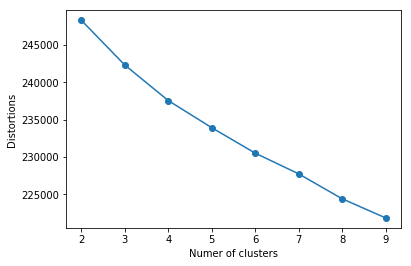

In [17]:
# TODO: Plot clusters from 2 to 9.  Hint: you can be more efficient
# by writing a reusable plot_clusters function
# Worth 5 points
try:
    def plot_clusters(matrix, cluster_max):
        distortions_lst = test_cluster_size(matrix, cluster_max)
        plt.plot(range(2,len(distortions_lst)), distortions_lst[2:], marker = 'o')
        plt.xlabel('Numer of clusters')
        plt.ylabel('Distortions')
        plt.show()
        opt_k = distortions_lst.index(min(distortions_lst[2:]))
        return (opt_k)

        
        
    plot_clusters(X,9)
    
# YOUR CODE HERE
except:
    raise NotImplementedError()

In [18]:
opt_k = 9

In [19]:
if opt_k < 2 or opt_k > 9:
    raise ValueError('Bad optimal k')
    

Now, if your data looked like ours, you probably didn't see a 100% convincing elbow on the data (though there might have been something that *could* be interpreted as an elbow).

## Step 1.4: Feature Scaling

Perhaps we have odd feature scaling along some dimensions, because some words are more frequent than others.  Let’s see whether we should use the raw counts (as above), min-max scaling, Boolean value indicating appears/doesn’t appear, or log-scaled values.

### Step 1.4.1. Scaling by min-max

Given an input matrix X, we can rescale each feature along its min/max value range, as follows:

In [20]:
X_copy = X.copy()

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_copy)


Now plot the number of clusters (from 2 to 8) vs distortion.  Can you find a clear “elbow” here?  Set `opt_k` to the number of clusters you think represents the elbow.

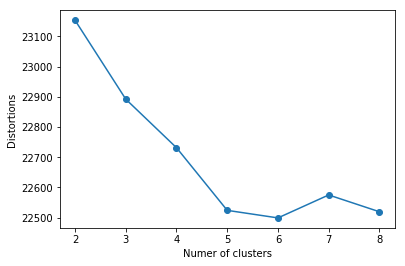

In [21]:
# TODO: Use scaled frequencies rather than raw frequencies to evaluate the distortion.
# Worth 3 points
try:
    plot_clusters(X_scaled,8)

# YOUR CODE HERE
except:
    raise NotImplementedError()

In [95]:
opt_k = 5

In [96]:
if opt_k <= 1 or opt_k > 8:
    raise ValueError('Bad optimal k')
    

### Step 1.4.2. Boolean present/absent

As an alternative, try replacing all elements of the matrix with 1 if they are nonzero (make sure to use Pandas functions, no loops). This corresponds to the Boolean case.  Make this a matrix `X_binary`.

Again, plot the number of clusters (from 2 to 8) vs distortion.  Find the “elbow” after which the change in distortion tapers off notably.  Set `opt_k` to this.


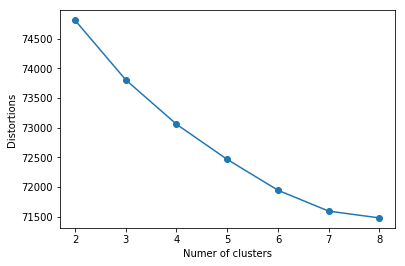

In [24]:
# TODO: Convert to Boolean values depending on whether there are 0s or non-0s.
# Worth 5 points
try:
    X_binary = X.copy()
    X_binary[X_binary != 0] = 1
    plot_clusters(X_binary, 8)

    
# YOUR CODE HERE
except:
    raise NotImplementedError()

In [25]:
opt_k = 8

In [26]:
if opt_k < 2 or opt_k >= 9:
    raise ValueError('Bad optimal k')
    

### Step 1.4.3. Log scaling

As yet another alternative, try adding 1 to all elements in the original matrix and then take the numpy log of all elements in the original matrix. This is the NLP-inspired version, since word frequencies are informative but follow a Zipfian distribution. Call this matrix `X_log`.

Again, plot the number of clusters (from 2 to 8) vs distortion.  Find the “elbow” after which the change in distortion tapers off notably.  Set `opt_k` to this.

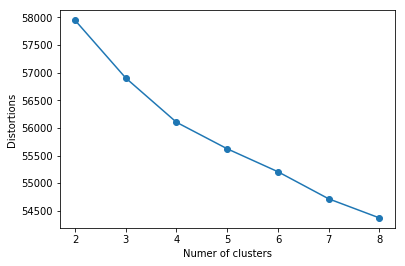

In [27]:
# TODO: Use log frequencies rather than raw frequencies to evaluate the distortion.
# Worth 3 points
try:
    X_log = X.copy()
    X_log = X_log + 1
    X_log = np.log(X_log)
    plot_clusters(X_log,8)
    
# YOUR CODE HERE
except:
    raise NotImplementedError()

In [28]:
opt_k = 8

In [29]:
if opt_k < 2 or opt_k >= 9:
    raise ValueError('Bad optimal k')
    

## Step 1.5 The Variance Ratio Criterion

Recall from lecture that we can compute a different distortion metric called the Variance Ratio Criterion ($VRC$), given by

$$ VRC(k) = \frac{SS_B}{k-1} / \frac{SS_W}{N - k}$$

where $SS_B$ is the sum of squared distance between the cluster centers and the grand mean (calculated per data point), $k$ is the number of clusters, $SS_W$ is the sum of square distance between data points and their assigned cluster centers, and $N$ is the number of data points.


### Step 1.5.1 The Grand Mean

As a quick check, please compute the grand mean of the original dataset in the cell below. Store it in the variable `grand_mean` so we can test it. Do not use a loop.

In [30]:
# Compute the grand mean here
try:
    grand_mean = np.mean(X, axis = 0)
# YOUR CODE HERE
except:
    raise NotImplementedError()


In [31]:
grand_mean
    

array([0.01899593, 0.01085482, 0.96200814, ..., 0.00678426, 0.00949796,
       0.00542741])

### Step 1.5.2 Implementing VRC

Write a function `test_vrc(data, max_num_cluster)` that computes the $VRC$ on clusterings of size 2 up to size `max_num_cluster`. Since we are passing in the data, compute a new grand mean within the function. However, since the grand mean does not depend on the clusters, you should not compute it within a loop. Note that $SS_W$ is the distortion metric that you used in Steps 1.3 and 1.4.

**Using the original version of your data, so not the scaled, binary, or log versions**, plot the number of clusters (from 2 to 8) vs $VRC$.  Set `opt_k` to the number of clusters recommended by $VRC$. Note that you are now looking for the first or highest local maximum and not looking for an elbow.

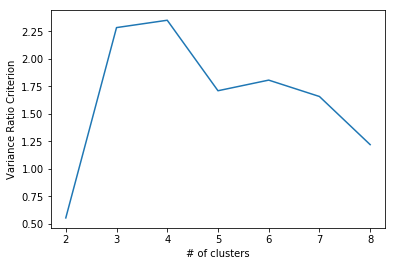

In [32]:
# TODO: plot VRC and find opt_k
# Worth 5 points
try:
    def test_vrc(data, max_num_cluster):
        scores = [None,None]
        grand_mean = np.array([np.mean(data,axis = 0)])
        for i in range(2, max_num_cluster + 1):
            km = KMeans(n_clusters=i,
                        init='random',
                        n_init=30,
                        max_iter=300,
                        random_state=0)
            km_model = km.fit(data)
            cls_groups = np.array([km_model.cluster_centers_[x,] for x in km_model.labels_])
            SSb = sum(cdist(cls_groups, grand_mean, 'euclidean'))
            scores.append(float((SSb/(i-1))/(km_model.inertia_/ (len(data)-1))))

        plt.plot(range(2,max_num_cluster +1),scores[2:])
        plt.xlabel('# of clusters')
        plt.ylabel('Variance Ratio Criterion')
        plt.show()
        return scores
    test_vrc(X,8)
    
# YOUR CODE HERE
except:
    raise NotImplementedError()

In [33]:
print(X)

[[7. 1. 3. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]]


In [34]:
if opt_k < 2 or opt_k >= 9:
    raise ValueError('Bad optimal k')
    

## Step 1.6: Dimensionality Reduction via PCA

Maybe we don’t need every word to be a separate dimension.  Let’s use PCA to find the most important features.  We're going to create a PCA model with 700 components, fit it to our scaled data, and then plot how much each feature (cumulatively) affects the variance, all with this code.

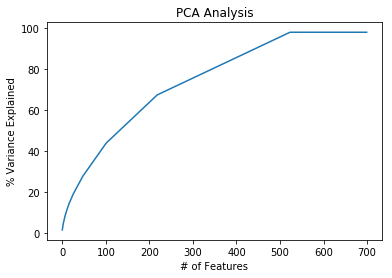

In [35]:
# This part is just to free up some memory
bbc_df = pd.DataFrame({})

X_forPCA = X_scaled.copy()
pca_model = PCA(n_components = 700)
pca_model.fit(X_forPCA)
variance = pca_model.explained_variance_ratio_ #calculate variance ratios                                         

var=np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features                                                          

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In the cell below, assign a value to `cutoff` (to the nearest multiple of 50) for an appropriate number of PCA dimensions.

In [36]:
cutoff = 500

In [37]:
if cutoff < 100:
    raise ValueError('Cutoff value is really small - are you sure?')
    

Re-run PCA with `n_components` equal to that value, and run `fit_transform` on `X_forPCA` to get an updated feature matrix. Now plot the number of clusters (from 2 to 12) vs $VRC$ using the PCA-transformed data and assign the best `k` to `opt_k`. Remember, you are looking for a local maximum.

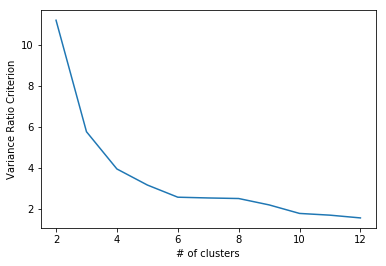

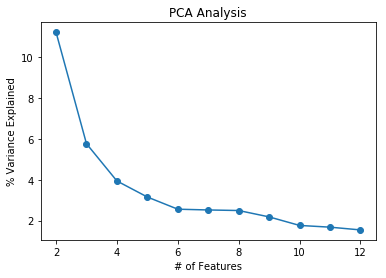

In [38]:
# TODO: set X_PCA
# Worth 5 points
try:
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components = cutoff)
    X_PCA = pca.fit_transform(X_forPCA)
    
    pca_distortion = test_vrc(X_PCA,12)
    plt.plot(range(2,len(pca_distortion)), pca_distortion[2:], marker = 'o')
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    

# YOUR CODE HERE
except:
    raise NotImplementedError(X_forPCA)

In [39]:
opt_k = 2

In [40]:
assert(X_PCA.shape == (737,cutoff))

if opt_k < 2 or opt_k >= 9:
    raise ValueError('Bad optimal k')
    

## Step 1.5: Evaluating Cluster Results

Now we are going to compare the true labels with the clusters. Note that the clusters are numbered 0 to $k-1$, but even if $k = 5$, these numbers are likely not in the same order as (athletics, cricket, football, rugby, tennis). So, write a function `evaluate_clusters(data, cls, k)` that does the following:

1. Cluster `data` into `k` clusters. `cls` should contain the same number of rows as data, but contain the indices of the true labels in the column `class_label`.
1. Determine the index of the true label associated with each cluster.  To do this, you’ll need to compute the index of the most common true label in each cluster. Use the `mode` function that you have already imported.
2. Map the output of the clustering to the integers that you found. You could print this mapping for extra insight, but this is not required.
2. Count the number of correctly classified articles and return the proportion of correctly classified articles.

For extra insight, you could use `nltk.FreqDist` to print the size of each cluster, but this is not required.

In [82]:
# Write your evaluate_clusters(data, cls, k) function here.
try:
    def evaluate_clusters(data, cls, k):

        km = KMeans(n_clusters = k,
                    init = 'random',
                    n_init = 30,
                    max_iter = 300,
                    random_state = 0)

        cluster_label = km.fit_predict(data)

        #loop through all indices in predicted labels
        index = 0
        #intialize the number of correctly classified labels
        correct = 0
        lst = []

        for k in range(k):
            for j in cluster_label:
                if j == k :
                    lst.append(cls[index])
                index +=1

            for x in lst:
                if x == mode(lst):
                    correct +=1
            lst = []
            index = 0
        baseline_accuracy = correct/len(data)

        return baseline_accuracy
        
# YOUR CODE HERE
except:
    raise NotImplementedError()

In [83]:
baseline_accuracy = evaluate_clusters(X, document_class, 5)
print(baseline_accuracy)


0.44776119402985076


Among your 4 versions of the dataset and choices of number of clusters between 2 and 8, find the best configuration and report your accuracy value. Store the best version of your data as `opt_data` and the best $k$ as `opt_k`. Rather than posting on Piazza about the "right answer", please take this opportunity to explore. The test cases for this part will accept more than the absolute best configuration. You just have to be pretty close.

In [100]:
# Set opt_data and opt_k in this cell.
cls = [X,X_scaled,X_binary,X_log]
k = [9,6,8,8] 
baseline_accuracy_lst = []
for i in range(len(cls)):
    x = evaluate_clusters(cls[i],document_class,k[i])
    baseline_accuracy_lst.append(x)

print(baseline_accuracy_lst)

opt_data = X
opt_k = 9

[0.6404341926729986, 0.47761194029850745, 0.6363636363636364, 0.6227951153324288]


In [99]:
best_accuracy = evaluate_clusters(opt_data, document_class, opt_k)
print(best_accuracy)


0.6404341926729986
